# Navigation Control using Reinforcement Learning
This project solves a navigation task for the Unity ML-Agents ***Banana*** environment. An agent is trained using the Double DQN algorithm to navigate and collect bananas in a large square world.

For information on the environment see ***README.md***. For a detailed description of the training algorithm, see ***Report.md***.

## Import packages

In [1]:
import collections
import numpy as np
import torch
from unityagents import UnityEnvironment
from agents import DQNAgent
from matplotlib import pyplot as plt
%matplotlib inline

## Start the environment
There are prerequisites that need to be installed for running this project. Install the prerequisites as mentioned in the project README. After you have downloaded the platform-specific environment, specify the ***file_name*** variable as appropriate.

In [2]:
# Specify the Unity environment as per platform
file_name = "./Banana.app"                         # Mac OSX
#file_name = "./Banana_Linux/Banana.x86"            # Linux 32 bit
#file_name = "./Banana_Linux/Banana.x86_64"         # Linux 64 bit
#file_name = "./Banana_Windows_x86/Banana.exe"      # Windows 32 bit
#file_name = "./Banana_Windows_x86_64/Banana.exe"   # Windows 64 bit

# create environment
env = UnityEnvironment(file_name)

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=False)[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


## Create the agent

The reinforcement learning agent for this project is trained using the Double DQN algorithm. The implementation can be found in ***agents.py***. Specify the set of hyperparameters for training the agent.

In [3]:
BUFFERSIZE = int(1e6)    # Experience buffer size
GAMMA = 0.99             # Discount factor
EPSILON = 0.95           # Epsilon parameter for exploration
DECAY = 1e-5             # Epsilon decay rate
EPMIN = 0.1              # Minimum value of epsilon
MINIBATCHSIZE = 64       # Batch size for sampling from experience replay
LEARNRATE = 2e-4         # Learn rate of Q network
TAU = 1e-3               # Target network update factor
MAX_EPISODES = 5000      # Maximum number of training episodes
AVG_WINDOW = 100         # Window length for calculating score averages
MAX_STEPS_PER_EPISODE = 1000    # Maximum agent steps per episode

Create the agent.

In [4]:
# get the observations and action dimensions from the environment
osize = len(env_info.vector_observations[0])
asize = brain.vector_action_space_size
seed = 0
# create the DQN agent
agent = DQNAgent(osize,asize,seed,BUFFERSIZE,GAMMA,EPSILON,DECAY,EPMIN,MINIBATCHSIZE,LEARNRATE,TAU)

## Train the agent
To train the agent run the code cell below. Training is computationally intensive and may take several minutes. To watch a pre-trained agent, skip to the next section.

By default, the training will print metrics in the console. To change the verbosity, set the ***VERBOSE*** variable to True or False.

In [5]:
# log scores
reward_log = []
avg_log = []
avg_window = collections.deque(maxlen=AVG_WINDOW)

# verbosity
VERBOSE = True

# Train the agent
for ep_count in range(1,MAX_EPISODES):

    # reset the environment
    env_info = env.reset(train_mode=True)[brain_name]
    state = env_info.vector_observations[0]
    
    ep_reward = 0
    
    for t in range(1,MAX_STEPS_PER_EPISODE):
        # sample action from the current policy
        action = agent.get_action(state)
        
        # step the environment
        env_info = env.step(action)[brain_name]
        next_state = env_info.vector_observations[0]
        reward = env_info.rewards[0] 
        done = env_info.local_done[0]
        
        # step the agent
        agent.step(state,action,reward,next_state,done)
        
        state = next_state
        ep_reward += reward
        
        # terminate if done
        if done:
            break
    
    # print training progress
    avg_window.append(ep_reward)
    avg_reward = np.mean(avg_window)
    avg_log.append(avg_reward)
    reward_log.append(ep_reward)
    if VERBOSE and (ep_count==1 or ep_count%100==0):
        print('Episode: {:4d} \tEpisode Reward: {:4.2f} \tAverage Reward: {:4.2f} \tEpsilon: {:6.4f} \tLoss: {:6.4f}'.format(ep_count,ep_reward,avg_reward,agent.epsilon,agent.loss_log[ep_count]))
    
    # check if env is solved
    if avg_reward >= 13:
        print('\nEnvironment solved in {:d} episodes!\tAverage Reward: {:.2f}'.format(ep_count, avg_reward))
        torch.save(agent.Q.state_dict(), 'checkpoint.pth')
        break

Episode:    1 	Episode Reward: 0.00 	Average Reward: 0.00 	Epsilon: 0.9472 	Loss: 0.0205
Episode:  100 	Episode Reward: 2.00 	Average Reward: 0.62 	Epsilon: 0.7038 	Loss: 0.0094
Episode:  200 	Episode Reward: 6.00 	Average Reward: 3.75 	Epsilon: 0.5214 	Loss: 0.0064
Episode:  300 	Episode Reward: 6.00 	Average Reward: 6.35 	Epsilon: 0.3862 	Loss: 0.0053
Episode:  400 	Episode Reward: 11.00 	Average Reward: 8.65 	Epsilon: 0.2861 	Loss: 0.0058
Episode:  500 	Episode Reward: 12.00 	Average Reward: 10.28 	Epsilon: 0.2120 	Loss: 0.0053
Episode:  600 	Episode Reward: 15.00 	Average Reward: 11.03 	Epsilon: 0.1570 	Loss: 0.0044
Episode:  700 	Episode Reward: 12.00 	Average Reward: 12.39 	Epsilon: 0.1163 	Loss: 0.0029
Episode:  800 	Episode Reward: 17.00 	Average Reward: 12.93 	Epsilon: 0.1000 	Loss: 0.0030

Environment solved in 828 episodes!	Average Reward: 13.02


Plot the training results. The results will be saved in the ***results.png*** file.

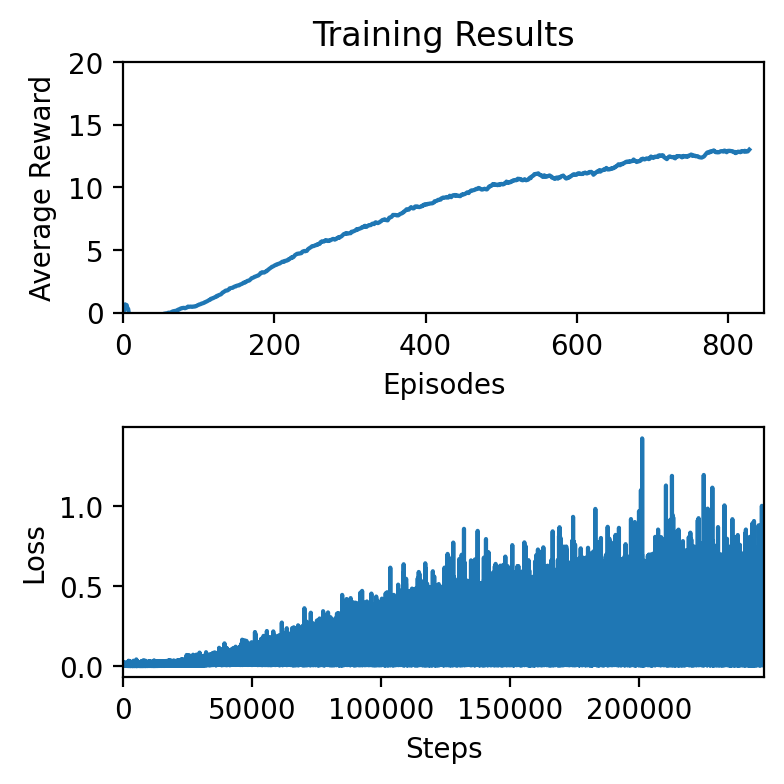

In [6]:
# plot score history
plt.ion()
fig, axarr = plt.subplots(2,1, figsize=(4,4), dpi=200)
ax1 = axarr[0]
ax1.set_title("Training Results")
ax1.set_xlabel("Episodes")
ax1.set_ylabel("Average Reward")
ax1.set_xlim([0, ep_count+20])
ax1.set_ylim([0, 20])
ax1.plot(range(1,ep_count+1),avg_log)

# plot loss
ax2 = axarr[1]
ax2.set_xlabel("Steps")
ax2.set_ylabel("Loss")
ax2.set_xlim([0, agent.stepcount+20])
ax2.plot(agent.loss_log)

fig.tight_layout(pad=1.0)
plt.show()
fig.savefig('results.png',dpi=200)

## Simulate a smart agent

In this section, you will load the network weights from a pre-trained agent and use them to simulate the environment. To simulate the agent from an immediate training session, comment the line of code where the weights are loaded from the **checkpoint.pth** file.

In [ ]:
# load the weights from file
agent.Q.load_state_dict(torch.load('checkpoint.pth'))

# number of simulations
NUM_SIMS = 3

for i in range(NUM_SIMS):
    
    # reset the environment
    env_info = env.reset(train_mode=False)[brain_name]
    state = env_info.vector_observations[0]
    
    for t in range(1,MAX_STEPS_PER_EPISODE):
        # sample action
        action = agent.get_action(state)
        
        # step the environment
        env_info = env.step(action)[brain_name]
        next_state = env_info.vector_observations[0]
        reward = env_info.rewards[0] 
        done = env_info.local_done[0]
        
        state = next_state
        if done:
            break 
            
env.close()